# 住宅販売価格の予測

データセットダウンロード元  
https://www.kaggle.com/harlfoxem/housesalesprediction/data

以下の流れで処理を行う

1. 基礎集計、グラフ化
2. データ前処理
3. 特徴量抽出
4. モデルの学習
5. モデルの評価

## 0. 実行前準備

In [1]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df_data = pd.read_csv("1_data/kc_house_data.csv")
df_data["price"] = df_data["price"] / 10**6 #単位を10万ドルにしておく

## 1.基礎集計、グラフ化

In [3]:
print(df_data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


### カラムメタデータ

|  ラベル | 概要 | 種別 |
---|---|---
| id | ID | 数値 |
| date | 販売日 | 文字列 |
| price | 価格(予測対象) | 数値 |
| bedrooms | ベッドルームの数 | 数値 |
| bathrooms | バスルームの数 | 数値 |
| sqft_living | リビングルームの広さ | 数値 |
| sqft_lot | 駐車場の広さ | 数値 |
| floors | 階数 | 数値 |
| waterfront | ウォーターフロントを望む家(0,1) | 文字列 |
| view | ビューの種類(0,1,2,3,4) | 文字列 |
| condition | 状態（1,2,3,4,5) | 文字列 |
| grade | グレード(1~13) | 文字列 |
| sqft_above | 地上階の広さ | 数値 |
| sqft_basement | 地下の広さ | 数値 |
| yr_built | 建築年 | 数値 |
| yr_renovated | 家が改築された年 | 数値 |
| zipcode | 郵便番号 | 数値 |
| lat | 緯度座標 | 数値 |
| long | 経度座標 | 数値 |
| sqft_living15 | 近所15件の平均のリビングの広さ | 数値 |
| sqft_lot15 | 近所15件の駐車場の広さ | 数値 |

参照）https://www.slideshare.net/ssuserb5817c/python-66169435  
補足)アメリカの住宅のバスルームの数え方 https://ameblo.jp/ayako-america/entry-11781058914.html

In [4]:
stringLabels = ["date","waterfront","view","condition","grade"]

方針）　文字列データはone-hotベクトルに変換する

### ヘッダを表示

In [5]:
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,0.2219,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,0.5380,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,0.1800,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,0.6040,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,0.5100,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


方針）　dateは日付型に変換する

In [6]:
df = df_data.drop(stringLabels+ ["id"],axis=1)

方針) idは価格に影響しないと考えられるため削除

### 散布図

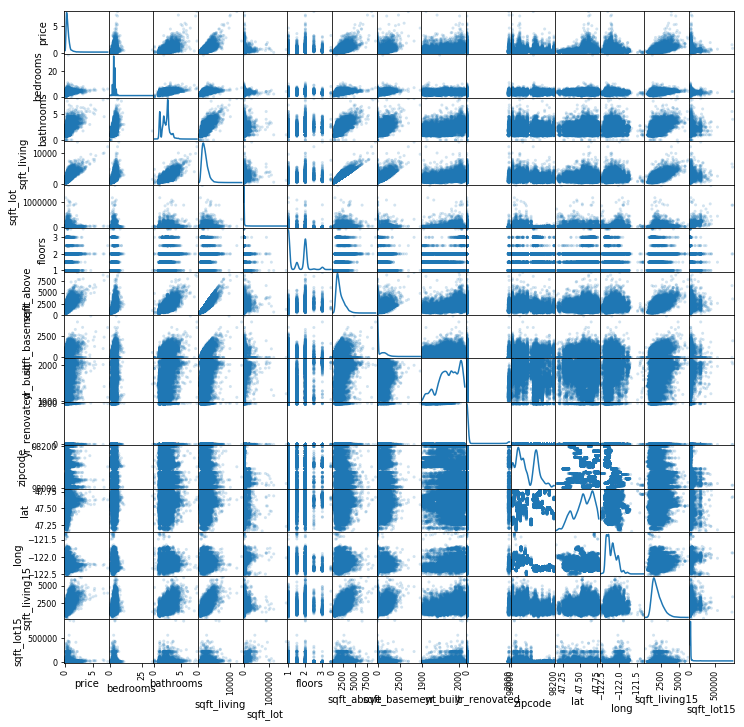

In [7]:
plt.figure()
scatter_matrix(df,alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

考察）floors,zipcode,lat,longは有効か要検討

### ヒートマップ

In [8]:
#相関行列
df.corr().style.background_gradient().format('{:.2f}')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.00,0.31,0.53,0.70,0.09,0.26,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.31,1.00,0.52,0.58,0.03,0.18,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.53,0.52,1.00,0.75,0.09,0.50,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,0.70,0.58,0.75,1.00,0.17,0.35,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,0.09,0.03,0.09,0.17,1.00,-0.01,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.26,0.18,0.50,0.35,-0.01,1.00,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
sqft_above,0.61,0.48,0.69,0.88,0.18,0.52,1.00,-0.05,0.42,0.02,-0.26,-0.00,0.34,0.73,0.19
sqft_basement,0.32,0.30,0.28,0.44,0.02,-0.25,-0.05,1.00,-0.13,0.07,0.07,0.11,-0.14,0.20,0.02
yr_built,0.05,0.15,0.51,0.32,0.05,0.49,0.42,-0.13,1.00,-0.22,-0.35,-0.15,0.41,0.33,0.07
yr_renovated,0.13,0.02,0.05,0.06,0.01,0.01,0.02,0.07,-0.22,1.00,0.06,0.03,-0.07,-0.00,0.01


- 相関性が70%以上と高い項目）　　
 - priceとsqft_living
 - bathroomsとsqft_living
 - sqft_livingとgrade
 - sqft_livingとsqft_above
 - sqft_livingとsqft_living15
 - sqft_lotとsqft_lot15
 - gradeとsqft_living15
 - sqft_living,sqft_above,sqft_lot,sqft_lot15,sqft_living15は相関性が高い項目が複数ある。

考察） 多重共線性の可能性あり 。相関性が高い項目に対して多重共線性がないか確認する

### 多重共線性の確認

In [9]:
delta = 1e-04
for cname in df.columns:  
    y=df[cname]
    X=df.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    rsquared = regr.score(X,y)
    vif = 1/(1-rsquared+delta)
    if vif >= 10:
        print(cname, ":", vif, ":", rsquared)

sqft_living : 10000.0 : 1.0
sqft_above : 10000.0 : 1.0
sqft_basement : 10000.0 : 1.0


方針）　VIFが10以上の上記の項目は前処理で削除する

### 欠損地の確認

In [10]:
df_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

考察）欠損値はない

### 価格の分布

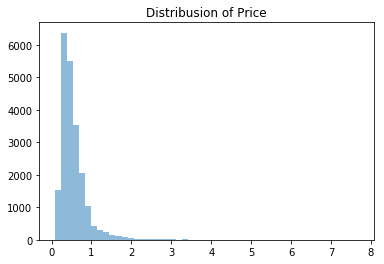

In [11]:
plt.hist(df['price'], bins=50, alpha=0.5)
plt.title('Distribusion of Price')
plt.show()

考察） 横軸が極端に長いので外れ値があるかもしれない

### 基本統計量

In [12]:
df.describe ()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,0.540088,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,0.367127,0.930062,0.770163,918.440897,4.142051e+04,0.539989,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,0.075000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,0.321950,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,0.450000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,0.645000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 箱ひげ図
外れ値を確認

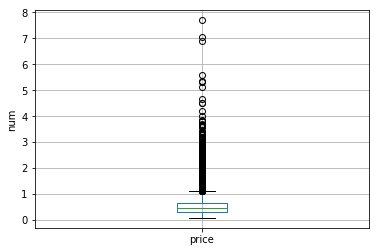

In [13]:
df_data.boxplot(column='price')
plt.ylabel("num")
plt.show()

### 外れ値を削除した場合の箱ひげ図

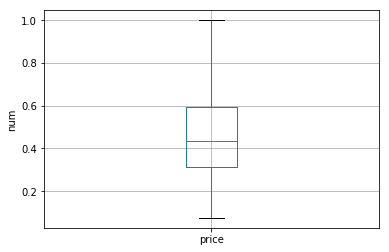

In [14]:
df2 = df_data[df_data["price"] < 1.0]
df2.boxplot(column='price')
plt.ylabel("num")
plt.show()

方針) 価格 10万ドル以上は除外する

### 改築された年

In [15]:
# 古い
df_data['yr_renovated'].value_counts().sort_index().head(10)

0       20699
1934        1
1940        2
1944        1
1945        3
1946        2
1948        1
1950        2
1951        1
1953        3
Name: yr_renovated, dtype: int64

In [16]:
#新しい 
df_data['yr_renovated'].value_counts().sort_index().tail(10)

2006    24
2007    35
2008    18
2009    22
2010    18
2011    13
2012    11
2013    37
2014    91
2015    16
Name: yr_renovated, dtype: int64

In [17]:
# 改築されていない物件とされている物件の数
s_renov = (df_data['yr_renovated']  != 0).value_counts()
print('改築された物件数=',s_renov[True])
print('改築されていない物件数=',s_renov[False])
print('比率=','{0:.3}'.format(s_renov[True] / s_renov[False]*100),'%')

改築された物件数= 914
改築されていない物件数= 20699
比率= 4.42 %


In [18]:
# 1999年以降改築された物件とそれ以外の物件の数
s_renov = (df_data['yr_renovated']  > 1999).value_counts()
print('1999年以降に改築された物件数=',s_renov[True])
print('それ以外の物件数=',s_renov[False])
print('比率=','{0:.3}'.format(s_renov[True] / s_renov[False]*100),'%')

1999年以降に改築された物件数= 458
それ以外の物件数= 21155
比率= 2.16 %


方針）改築されている物件は全体の4%程度なので改築の時期は考慮せずに改築したかしないかの値に変換する

### まとめ
- "waterfront","view","condition","grade"はone-hotベクトルに変換する
- "date"は日付型に変換する(月のみ)
- idは削除する
- sqft_living,sqft_above,sqft_basementは削除する
- priceが10万ドル以上は外れ値として除外する
- 改築されたかどうかを２値化する

## 前処理

In [19]:
df_pre = df_data.copy()

### 日付変換

In [20]:
#　月に変換
df_pre['month'] = pd.to_datetime(df_pre.date).map(lambda x:x.month)

### 改築年を改築の有無に変更

In [21]:
df_pre['renovated_flag'] = np.array(df_pre['yr_renovated'] != 0)*1

### One-hot ベクトル化

In [22]:
df_pre = pd.get_dummies(df_pre,columns=['zipcode','month','waterfront','view','grade'])
df_pre.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated_flag', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', '

### 不要項目を削除

In [23]:
df_pre = df_pre.drop(['id','date','yr_renovated','sqft_living','sqft_above','sqft_basement'],axis=1)

### 前処理後のデータ確認

In [24]:
df_pre.columns.values

array(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'condition', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated_flag', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98105', 'zipcode_

In [25]:
df_pre.head()

,price,bedrooms,bathrooms,sqft_lot,floors,condition,yr_built,lat,long,sqft_living15,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,0.2219,3,1.00,5650,1.0,3,1955,47.5112,-122.257,1340,...,0,0,0,1,0,0,0,0,0,0
1,0.5380,3,2.25,7242,2.0,3,1951,47.7210,-122.319,1690,...,0,0,0,1,0,0,0,0,0,0
2,0.1800,2,1.00,10000,1.0,3,1933,47.7379,-122.233,2720,...,0,0,1,0,0,0,0,0,0,0
3,0.6040,4,3.00,5000,1.0,5,1965,47.5208,-122.393,1360,...,0,0,0,1,0,0,0,0,0,0
4,0.5100,3,2.00,8080,1.0,3,1987,47.6168,-122.045,1800,...,0,0,0,0,1,0,0,0,0,0


## 学習

### 訓練データとテストを分割

In [26]:
# Nanの除去
df = df_pre.dropna()

# scikit learnの入力形式に変換する
y = df['price'].as_matrix()
y = y.reshape(-1,1)
X = df.drop(columns='price').as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [27]:
# 学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)
print("決定係数=",regr.score(X_train,y_train))

決定係数= 0.8104114566985385


In [28]:
# 推論
y_pred = regr.predict(X_test)
y_pred

array([[0.88280901],
       [0.21222391],
       [0.66752376],
       ...,
       [0.41433926],
       [1.65154903],
       [0.41987201]])

In [29]:
y_test

array([[0.83995],
       [0.25   ],
       [0.55   ],
       ...,
       [0.375  ],
       [2.16   ],
       [0.45   ]])

In [30]:
y_pred - y_test

array([[ 0.04285901],
       [-0.03777609],
       [ 0.11752376],
       ...,
       [ 0.03933926],
       [-0.50845097],
       [-0.03012799]])

### 精度の評価

In [31]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse,3) )
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )

MSE=0.027
RMSE=0.164
MAE=0.096
